# Lab 4 -- Filtering

Previously, we have touched several critical techniques in signal processing, including some basic of signals, frequency analysis and auto-correlation analysis. Hopefully, you have gained enough experience for your individual project. Before you really enter that, let's discuss a different thing -- filtering. It is not an analysis skill but would be beneficial when processing the IoT signals. Real-world data is rarely pristine; more often, it's marred by noise that can obscure the signals we're interested in. To mitigate this, it's common practice to apply a filter to the signal before further processing. Filtering serves to eliminate unwanted components, enhancing signal clarity. In the frequency domain, it can remove specific frequency components, while in the temporal domain, it can "smooth" the signal, provided the appropriate parameters are selected.

There are numerous filter types, each suited to different applications. For the purpose of frequency-based filtering, we categorize filters into four main types: low-pass, high-pass, band-pass, and band-stop, each defined by the frequency range they affect. Additionally, we will explore several temporal-domain filters, such as the Hampel, Savitzky-Golay, and Kalman filters, offering you tools to tackle various signal processing challenges."


## Frequency Filter

Frequency-based filters can be broadly categorized into four types, each designed to serve a specific purpose in signal processing:

- Low-Pass: These filters allow signals with a frequency lower than a certain cutoff frequency to pass through while attenuating higher frequency signals. They're often used to remove high-frequency noise or to smooth out a signal.
  
- High-Pass: Opposite to low-pass filters, high-pass filters remove low-frequency components from a signal, allowing only those signals higher than the cutoff frequency to pass. They are useful in applications like sharpening images or isolating high-frequency signals.
  
- Band-Pass: Band-pass filters are designed to allow only a specific range of frequencies to pass through, attenuating signals outside this range. They're particularly useful in isolating signals within a particular frequency band from a broader spectrum.
  
- Band-Stop: These filters do the reverse of band-pass filters; they block a specific range of frequencies while allowing signals outside this range to pass. They're useful for eliminating unwanted frequencies or interference.

![Different Filters](example_data/filters.png)
  
There are numerous implementations and designs of these filters. Here, we mainly focus on **Butterworth filter**, which is renowned for its maximally flat frequency response in the passband. This means that within the range of frequencies allowed to pass, the signal's amplitude is maintained uniformly, avoiding distortions up to the cutoff frequency.

### High pass 

We first introduce high pass filter. A high-pass filter is a type of digital filter designed to pass signals with a frequency higher than a certain cutoff frequency while attenuating (reducing the amplitude of) signals with frequencies lower than the cutoff frequency. The exact frequency at which this transition occurs is known as the filter's **cutoff frequency**. 

Text(0, 0.5, 'Amplitude')

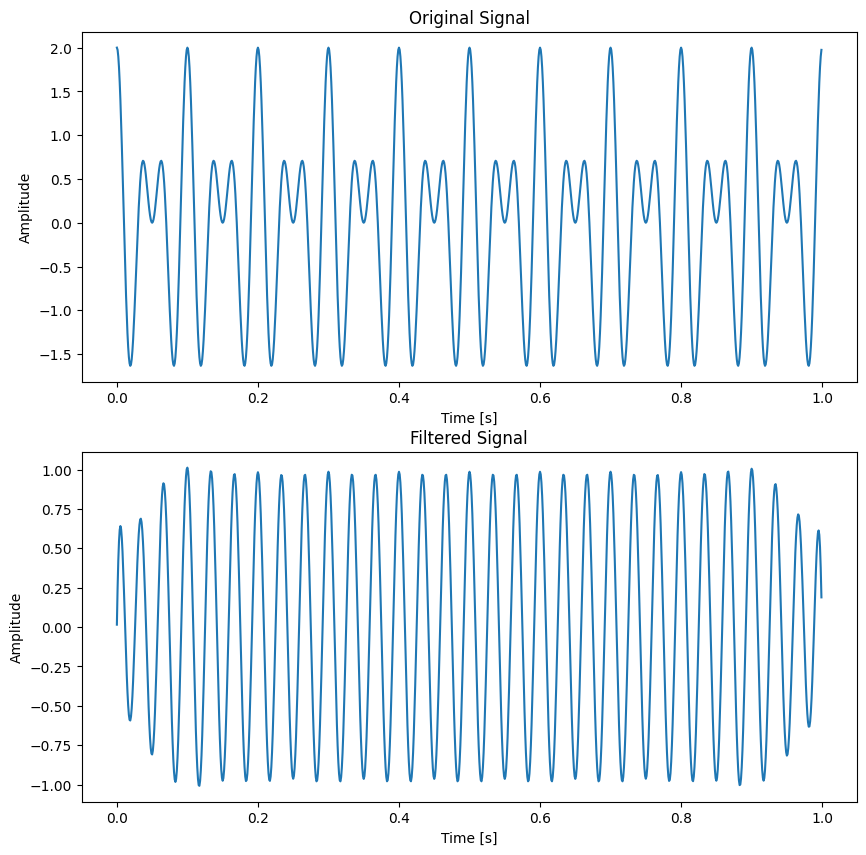

In [1]:
from scipy.signal import butter, sosfiltfilt
import numpy as np
from matplotlib import pyplot as plt

fs = 1000
t = np.arange(0,1,1/fs)
f1, f2 = 20, 30
s = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)

# high-pass filter
cutoff_freq = 25
# sos = butter(10, cutoff_freq/(fs/2), 'high', output='sos')
sos = butter(10, cutoff_freq, "high", fs=fs, output="sos")
s_filt = sosfiltfilt(sos, s)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(t, s)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2,1,2)
plt.plot(t, s_filt)
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


As you can see, we generate a sum of two pure tones, with frequency 20 and 30. Then we use `butter(output="sos")` to create a Butterworth filter. It will return the filter parameter `sos`. The signature of this function is given below:
```python
(function) def butter(
    N: Any,
    Wn: Any,
    btype: str = 'low',
    analog: bool = False,
    output: str = 'ba',
    fs: Any | None = None
) -> Any
```
Here's a breakdown of the function parameters for clarity:

- `N` means the order of the filter, essentially indicating the filter's complexity and sharpness in the frequency response. A higher order results in a steeper cutoff but requires more computational resources. Typically, this value is chosen between 2 and 12, balancing between filtration quality and computational efficiency. 

- `Wn` and `fs` are often paired. If `fs` is not given, you should normalize `Wn` according to the Ncquist frequency (i.e. `fs/2`). In other word, `butter(10, cutoff_freq/(fs/2))` and `butter(10, cutoff_freq, fs=fs)` are equivalent. 
  
- `btype` refers to the type of the filter. You can choose from `{'lowpass', 'highpass', 'bandpass', 'bandstop'}`. You can also use the alternives. For example, `highpass` can also be expressed in `high`, `h`, and `hp`. You can refer to the documents for more details.

- `output`: Second-order sections representation of the IIR filter. Only returned if `output='sos'`

This function returns `sos`, which is the parameter of the filter. Then you pass the parameter to `sosfiltfilt()` to get the filtered signal. 


After applying the high-pass filter, it's evident that frequencies below 25 Hz have been effectively attenuated, leaving the signal predominantly composed of the 30 Hz pure tone. This outcome highlights the filter's efficiency in isolating higher frequency components. However, it's crucial to remember that no filter operates flawlessly in practice. Despite the successful attenuation of lower frequencies, some degree of signal alteration or slight remnants of these frequencies may still persist.  In general, transient effects at the edges are unavoidable.

### Low Pass

A low-pass filter is a filter that passes signals with a frequency **lower than** a selected cutoff frequency and attenuates signals with frequencies higher than the cutoff frequency. We use the above example to illustrate how to create a low-pass filter.

Text(0, 0.5, 'Amplitude')

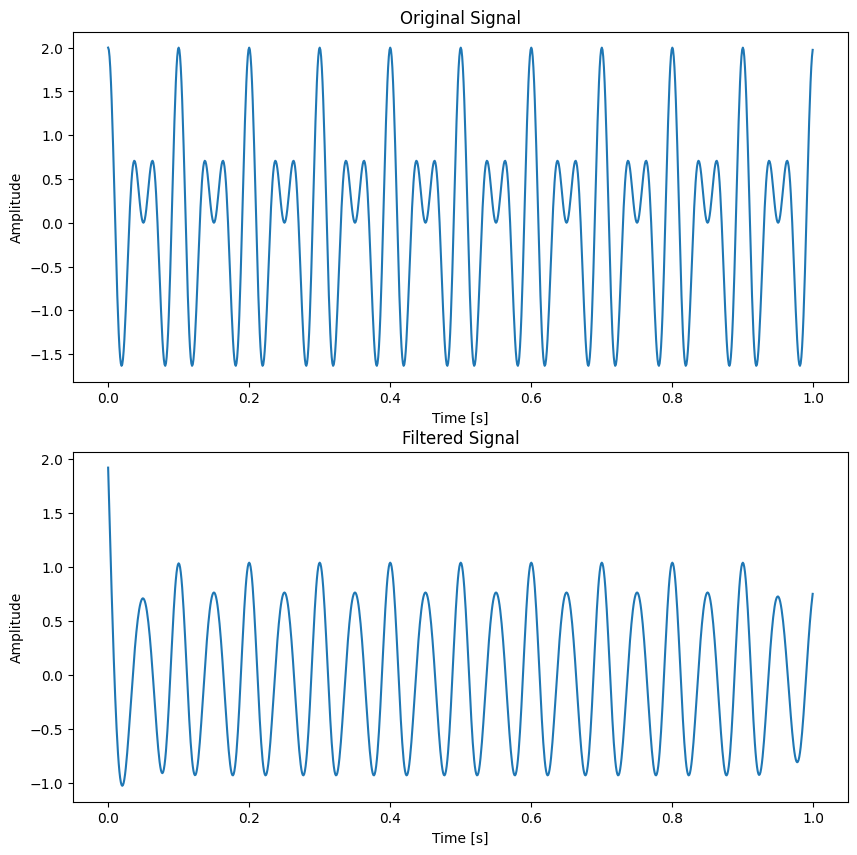

In [2]:
from scipy.signal import butter, sosfiltfilt
import numpy as np
from matplotlib import pyplot as plt

fs = 1000
t = np.arange(0,1,1/fs)
f1, f2 = 20, 30
s = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)

# low-pass filter
cutoff_freq = 25
# sos = butter(10, cutoff_freq/(fs/2), 'high', output='sos')
sos = butter(5, cutoff_freq, "low", fs=fs, output="sos")
s_filt = sosfiltfilt(sos, s)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(t, s)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2,1,2)
plt.plot(t, s_filt)
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

An important application of low-pass filter is removing the high-frequency noise. We will illustrate it via an example:

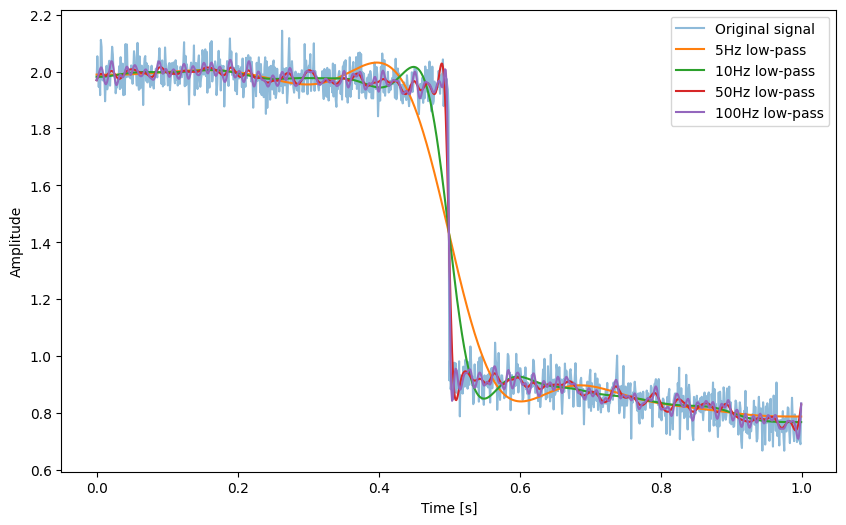

In [3]:
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt


rng = np.random.default_rng() # noise generator

fs = 1000 
t = np.arange(0, 1, 1/fs)
n = len(t)
x = 1 + (t < 0.5) - 0.25*t**2 + 0.05*rng.standard_normal(n)

sos0 = butter(4, 5, output='sos', fs=fs) # 5 Hz low-pass
y0 = sosfiltfilt(sos0, x)

sos1 = butter(4, 10, output='sos', fs=fs) # 10 Hz low-pass
y1 = sosfiltfilt(sos1, x)

sos2 = butter(4, 50, output='sos', fs=fs) # 50 Hz low-pass
y2 = sosfiltfilt(sos2, x)

sos3 = butter(4, 100, output="sos", fs=fs) # 100 Hz low-pass
y3 = sosfiltfilt(sos3, x)

plt.figure(figsize=(10, 6))
plt.plot(t, x, alpha=0.5, label='Original signal')
plt.plot(t, y0, label='5Hz low-pass',)
plt.plot(t, y1, label='10Hz low-pass')
plt.plot(t, y2, label='50Hz low-pass')
plt.plot(t, y3, label='100Hz low-pass')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

In the above example, we first generate a pulse wave with random noise. And we use low-pass filter with different cutoff frequency. It will exhibit different levels of smoothness. Below is another example, that adds random noise to the pure tone signal.

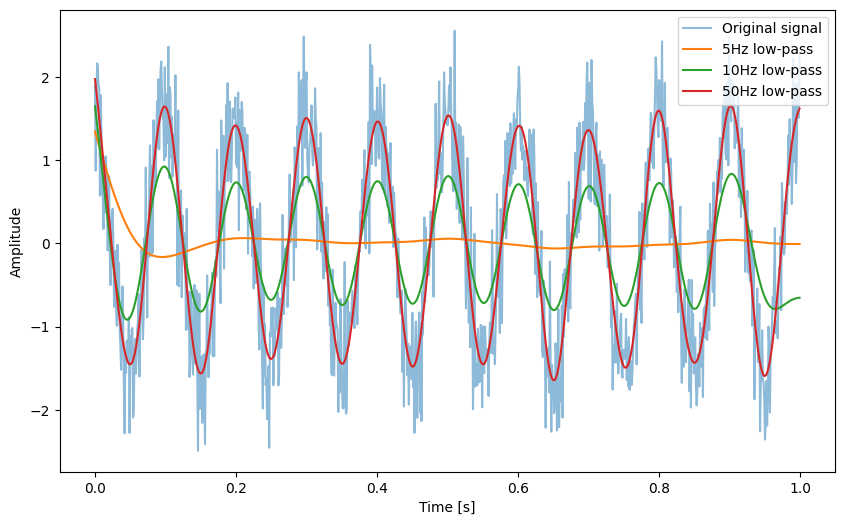

In [4]:
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt


rng = np.random.default_rng() # noise generator

fs = 1000 
t = np.arange(0, 1, 1/fs)
n = len(t)
f = 10
x = 1.5 * np.cos(2 * np.pi * f * t) + 0.5 * rng.standard_normal(n)

sos0 = butter(4, 5, output='sos', fs=fs) # 5 Hz low-pass
y0 = sosfiltfilt(sos0, x)

sos1 = butter(4, 10, output='sos', fs=fs) # 10 Hz low-pass
y1 = sosfiltfilt(sos1, x)

sos2 = butter(4, 20, output='sos', fs=fs) # 50 Hz low-pass
y2 = sosfiltfilt(sos2, x)


plt.figure(figsize=(10, 6))
plt.plot(t, x, alpha=0.5, label='Original signal')
plt.plot(t, y0, label='5Hz low-pass',)
plt.plot(t, y1, label='10Hz low-pass')
plt.plot(t, y2, label='50Hz low-pass')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')

### Band-pass and Band-stop

Following the exploration of high-pass and low-pass filters, which respectively allow frequencies above or below a certain cutoff frequency to pass through, we delve into band-pass and band-stop filters, each tailored for more specific frequency manipulation tasks. A band-pass filter is designed to permit only a specific range of frequencies to pass, effectively isolating a particular band of interest, which is invaluable in applications such as isolating voice signals from background noise or honing in on specific frequency components in electronic music production. Conversely, a band-stop filter, also known as a notch filter, serves the opposite purpose by attenuating frequencies within a certain range while allowing all others to pass, making it especially useful for eliminating unwanted noise or interference, such as the hum from electrical equipment or specific frequency bands in radio signal processing. Together, these four filter types constitute the foundational tools in frequency domain analysis and signal processing, offering versatile solutions for enhancing signal clarity and isolating or removing specific frequency components across a broad spectrum of applications.

We first take a look at ECG signal. If we care more about the heartrate, we can filter the ECG signal into the targeted band using band-pass filter. In this case, we know that the heartrate of this partcipant is between [48-120] BPM. Then we set the cutoff frequency accordingly with [0.8, 2]Hz. 

Text(0, 0.5, 'Amplitude')

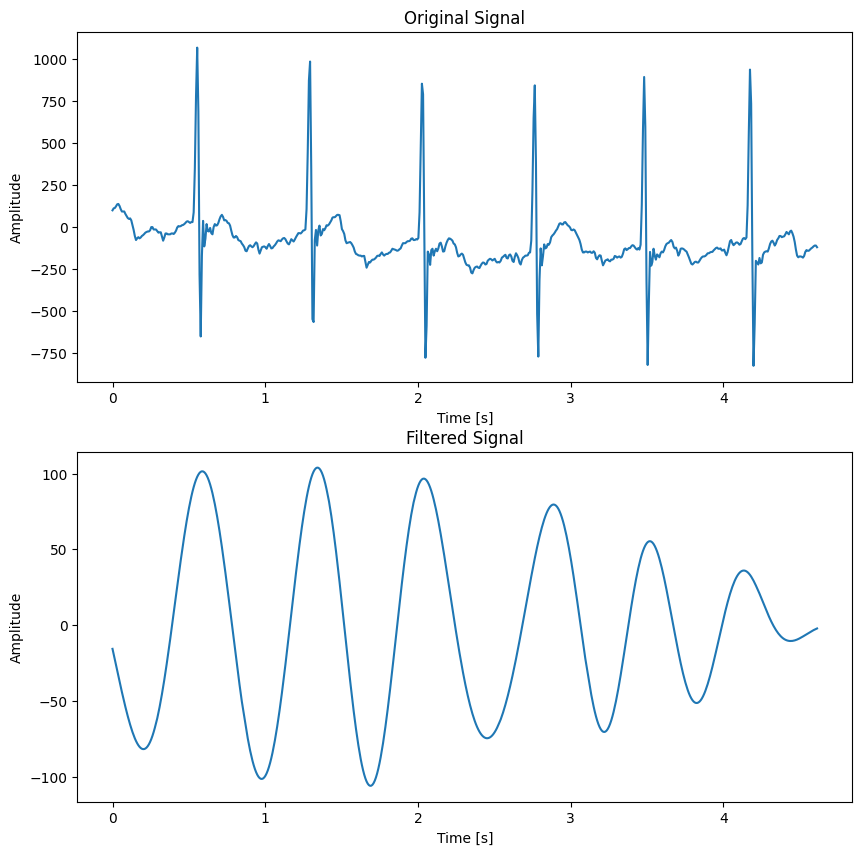

In [5]:
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt
import pickle 
import os.path as osp


data_path = f"example_data/ecg.pickle"
with open(data_path, "rb") as f:
    data = pickle.load(f)
    ecg = data["values"]
    times = data["times"]
    fs = 1 / (times[1] - times[0])




cutoff_freq = [0.8, 2]
sos = butter(3, cutoff_freq, "band", fs=fs, output="sos")
ecg_filt = sosfiltfilt(sos, ecg)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(times, ecg, label='Original signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.plot(times, ecg_filt, label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

As you can see, we smooth the original ECG data to get more smoothed information about the heartrate. This smoothing process, however, necessitates a compromise, as certain details may be obscured in exchange for clearer overall patterns.

The following illustrates the application of a band-stop filter, a crucial tool when dealing with measurements from electronic devices. Such measurements often suffer from power line interference, a pervasive issue characterized by distortions at either 50 Hz or 60 Hz, depending on geographic location. This interference can significantly muddle the signal, obscuring the vital information it carries. By implementing a band-stop filter, we effectively mitigate this interference, thereby preserving the integrity of the signal and ensuring more accurate readings. This technique is particularly valuable in environments where electronic noise is inevitable, allowing us to extract clean, usable data from the noise-laden raw signals.

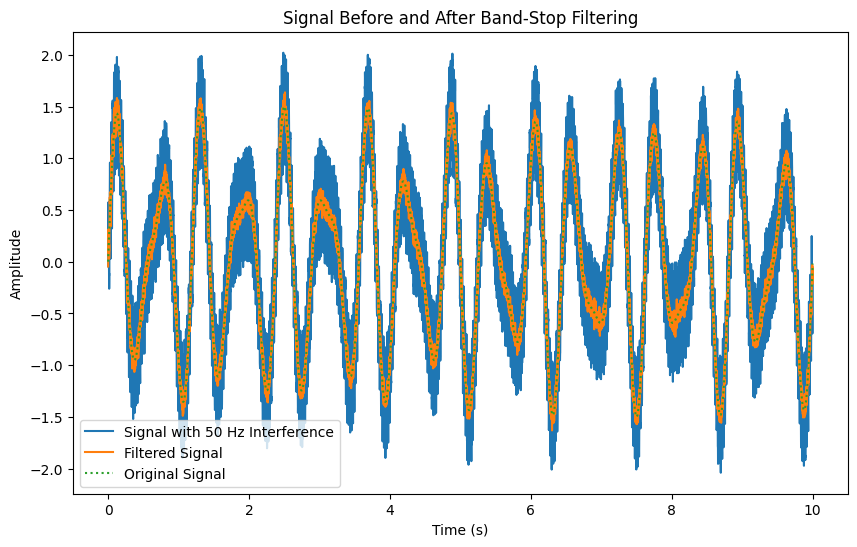

In [6]:
data_p = f"example_data/power_line.pickle"

with open(data_p, "rb") as f:
    data = pickle.load(f)
    interfered_signal = data["values"]
    fs = data["fs"]
    t = np.arange(0, len(interfered_signal)/fs, 1/fs)
    original_signal = data["origin_signal"]

# Define the stop band around the power line frequency (e.g., 49 to 51 Hz)
f_low = 49
f_high = 51

# Design the band-stop filter
sos = butter(N=4, Wn=[f_low, f_high], btype='bandstop', fs=fs, output='sos')
# Apply the band-stop filter
filtered_signal = sosfiltfilt(sos, interfered_signal)

# Plot the original, interfered, and filtered signals for comparison
plt.figure(figsize=(10, 6))

plt.plot(t, interfered_signal, label='Signal with 50 Hz Interference')
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.plot(t, original_signal, ":", label='Original Signal')
plt.title('Signal Before and After Band-Stop Filtering')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Other filters

### Hampel Filter

The Hampel filter is like a smart cleaner for your data, especially useful if you've already learned about filters that focus on frequencies, like the ones that let high or low tones through. Imagine you have a noisy signal, maybe from heart rate data or stock prices, and in this noise, there are some really wild points that just don't fit—these are what we call **outliers**. The Hampel filter steps in with a clever trick: it looks at each point in your data and checks if it's way too far from what's typical among its nearby points. It does this by comparing each point to the median of its neighbors, considering a set range around it, and if a point is too weird (too far from the median), the Hampel filter helps by adjusting it. This way, you keep the important patterns of your signal without letting those odd, out-of-place points throw you off track. It's great because it doesn't mess with the overall vibe of your data; it just cleans up the parts that don't belong, making your data analysis or signal processing clearer and more reliable.

We will use code to illustrate it. First, you have to install the module.

In [7]:
%pip install hampel

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/simple
Note: you may need to restart the kernel to use updated packages.


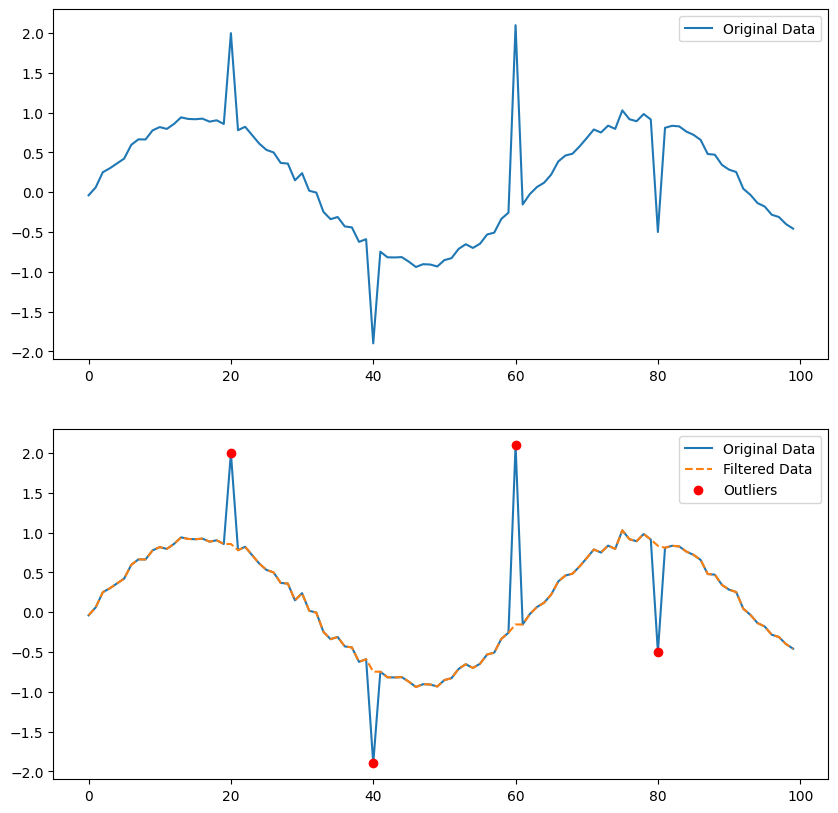

In [8]:
from hampel import hampel
import numpy as np
from matplotlib import pyplot as plt

data_p = f"example_data/outlier_data.pickle"

with open(data_p, "rb") as f:
    original_data = pickle.load(f)
    original_data = original_data["values"]

res = hampel(original_data, window_size=10, n_sigma=3.0,)
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(original_data, label='Original Data')
plt.legend()
plt.subplot(2,1,2)
plt.plot(original_data, label='Original Data')
plt.plot(res.filtered_data, label='Filtered Data', linestyle='--')
plt.plot(res.outlier_indices, original_data[res.outlier_indices], 'ro', label='Outliers')

plt.legend()


### Savitzky-Golay Filter

A Savitzky–Golay filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the precision of the data without distorting the signal tendency. There is an [GIF](https://en.m.wikipedia.org/wiki/File:Lissage_sg3_anim.gif) that shows the process of applying SG filter. 

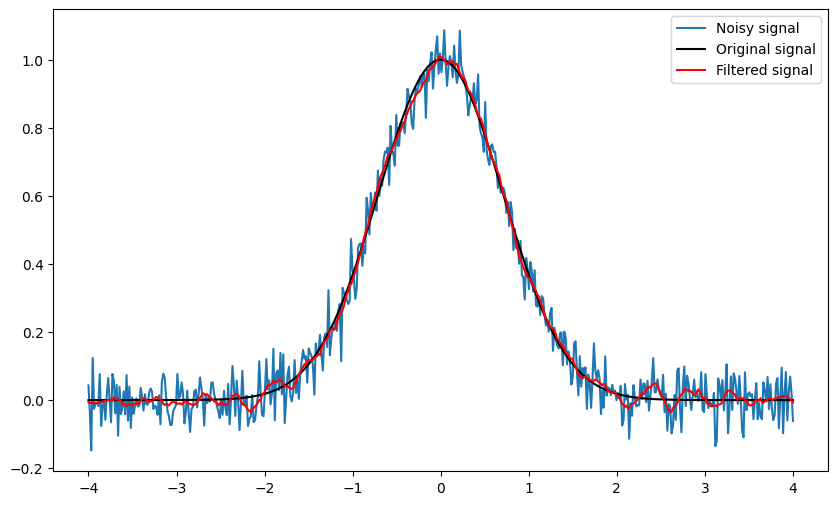

In [9]:
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt

t = np.linspace(-4, 4, 500)
original_signal = np.exp(-t ** 2)
s = original_signal + np.random.normal(0, 0.05, t.shape)

filtered = savgol_filter(s, 31, 4)
plt.figure(figsize=(10, 6))
plt.plot(t, s, label='Noisy signal')
plt.plot(t, np.exp(-t ** 2), 'k', lw=1.5, label='Original signal')
plt.plot(t, filtered, 'r', label='Filtered signal')
plt.legend()
plt.show()



Low-pass filters are best used when you need to remove high-frequency noise from a signal or preserve the low-frequency components of a signal, such as in audio processing or removing sharp spikes from data. They're ideal for applications where maintaining the integrity of slow-changing signals is crucial. On the other hand, the Savitzky-Golay filter is preferred for smoothing data without significantly distorting the signal's features, making it suitable for applications where preserving the signal's shape, like peak or trend detection in time series analysis, is important. The choice between them depends on whether frequency-specific filtering or smoothing while preserving signal structure is the goal.

## Programming Task

Please refer to `task_4.pdf` for more details.

After implementing the tasks, **please run `python check.py --uid <YOUR_UID>` before submitting.** This script performs automated tests on the examples provided in the docstrings. Failing these tests indicates potential critical issues in your code. Strive to resolve these problems. After that, it will create a zip file named after your `uid`. Make sure you enter the right `uid`. 

It's important to avoid changing the names of any files, including both the zip file and the program files contained within. Altering file names can lead to grading errors. Ensure that all file names remain as they are to facilitate accurate assessment of your work.

Your submission to **Moodle** should consist solely of the **generated `*.zip` file**. It is your responsibility to double check whether your submitted zip file includes your latest work. 